In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from imports import *

import acquire
import prepare
import explore
import model

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join data from each of the tables in the superstore database. The data obtained includes sales record transactions for SuperStore from 2014 - 2017. 

The `get_data` function performs this acquisition.

In [3]:
# acquire data from the Codeup cloud database
df = acquire.get_data()

Reading from local CSV...


# Preparation

In this stage, we clean and prepare the data for further exploration analsys and enccapsulate the relevant code in the prepare module.

The `prep_data` function accomplishes the following:

- renames columns for convenience
- casts date columns as datetime types
- resets the dataframe index as a datetime (order_date)
- adds engineered features:
    - profit-per-product
    - sales-per-product

In [4]:
df = prepare.prep_data(df)

#### Splitting the data

In order to retain the ability to use our insights to make predictions, we only explored interactions between variables for years 2014-2016 by splitting the dataframe into train and test based on year. The test dataframe contains information from 2017 and the train dataframe contains the previous years. 

The `split_data` function performs this action

In [5]:
# split data into train (2014-2016) and test (2017)
train, test = prepare.split_data(df)

train n= 1238
test n= 496


#### Handling Outliers

While an initial exploration of the data revealed significant outliers in sales and proft, we decided not to remove them for this project. 

Since our goal is to find a category of products that stand out from the others in terms of lower sales volume and higher profit margins, removing individual instances of products/sales that stand out (in the form of being outliers) is not justified in this analysis.

# Exploration

#### Is there a category of product that has significantly lower sales volume than the others?

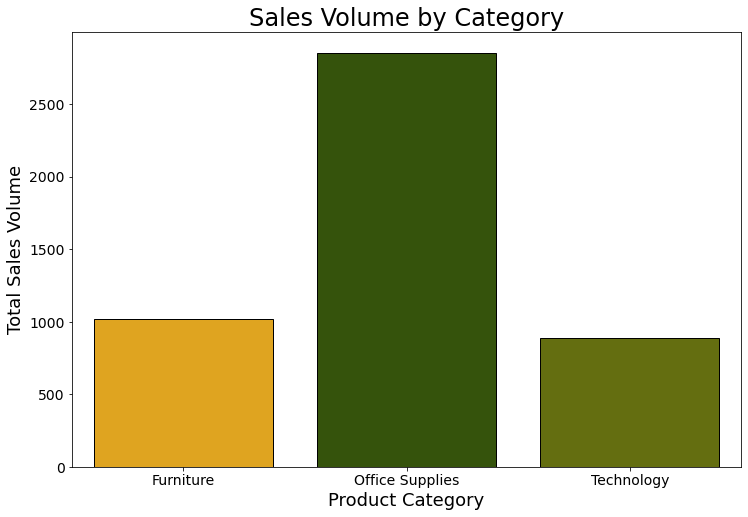

In [6]:
# create a seaborn barplot of total quantity by category
explore.sales_volume_by_category(train)

#### Is there a category of product that has higher profit-per-product than the others?

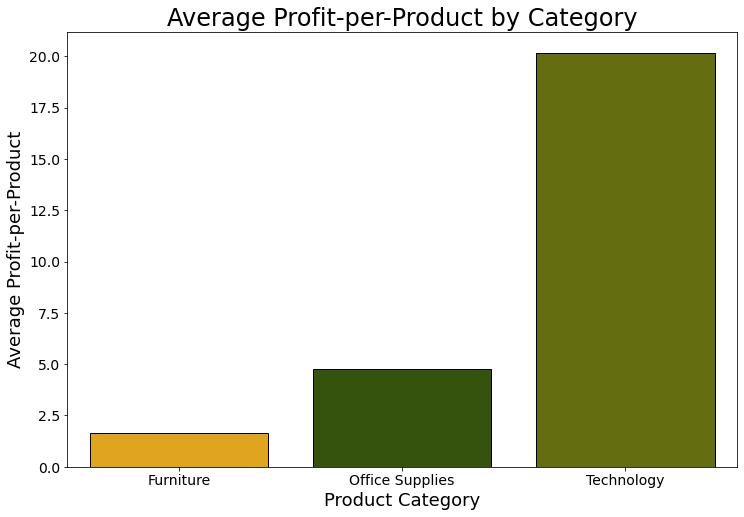

In [7]:
# create a seaborn barplot of mean profit-per-product by category
explore.profit_per_product_by_category(train)

We found that the Technology sector has far-and-away the highest profit margins, yet has plenty of room for growth in terms of sales volume. 

(These results were found to be statistically significant, see `explore_notebook.ipynb` for more information)

For these reasons, we will recommend expanding the Technology product line. 

# Analysis/Forecasting

To simulate an expansion of the technology product line, we will take a look at data for 2017 (test), and replicate all instances of sales of technology products, then add those duplicate instances back into the dataframe. This will simulate doubling sales volume, while maintaining the dimensionality of those sales (differing profit margins, etc).

The `create_projections_2` function simulates a scenario for 2017 that doubles sales in the Technology sector.

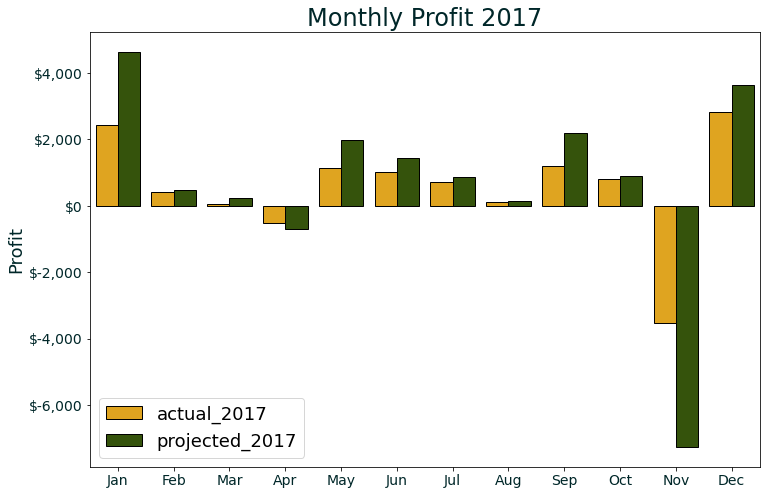

In [8]:
# create a dataframe containing projected profits for 2017
# based on duplicating 2017 sales,
projections = model.create_projections_1(test)

# create a seaborn barplot of actual vs projected profits for 2017
model.monthly_profit_barplot(projections)

While this resulted in higher profits in most months, we see that, in months where there were losses, those losses were also magnified. 

These magnified losses are likely due to duplicating sales that included significant discounts. 

For this reason, we also recommend discontinuing any discounts greater than 35%

The `create_projections_2` function simulates a scenario for 2017 that includes both recommendations.

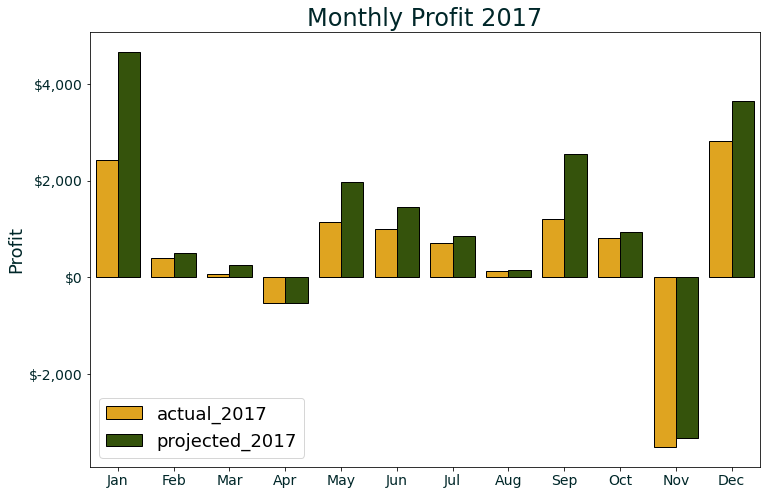

In [9]:
# create a dataframe containing projected profits for 2017
# based on duplicating 2017 sales, removing sales with discounts over .35
projections = model.create_projections_2(test)

# create a seaborn barplot of actual vs projected profits for 2017
model.monthly_profit_barplot(projections)

Now, we retain our gains in profit, while eliminating losses completely

In [10]:
# project monthly difference in profit
projections.difference_pct.mean()

0.631450651463487

In [11]:
# project annual difference in profit
(projections.projected_2017.sum() - projections.actual_2017.sum()) / projections.actual_2017.sum()

0.9649395879939442

In [12]:
# plot the cumulative sum of monthly profits using a seaborn lineplot
model.total_profit_lineplot(projections)

NameError: name 'profits' is not defined

<Figure size 864x576 with 0 Axes>

# Conclusion

If we had increased technology sales as suggested for the year 2017, we could have expected an average **monthly increase in profits of 63%**, yielding a **96% increase in total profit for the year**. 

Therefore, we strongly recommend conducting a similar analysis to determine which product line to expand in future years.`m

### Key Findings

We determined that the technology market has the best oppurtunity for expansion due to:

- highest profits per item
- lowest sales volume

### Recommendations

Profits on technology sales are higher than other markets. Additionally, sales volume is among the lowest categories. Based on profitability and projected room for growth, expansion efforts should be targeted on the technology sector.

### Next Steps

Given more time, we would like to:

- explore regional effects on profits
- explore regional effects on profits per market category
- explore office supplies as a secondary contender for expansion
- use time-series-analysis to predict 2018 profits, both with and without implementing our recommendations